In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Get data

In [ ]:
full_date_range = pd.DataFrame({'date': pd.date_range(start='2004-01-01', end='2024-01-01')})


In [ ]:
wsj_fx_signals = pd.read_csv('/content/drive/My Drive/CIS-5190-Project/Code/signals/wsj_fx_signals.csv', header = 0)
wsj_fx_signals['date'] = pd.to_datetime(wsj_fx_signals['date'])

In [ ]:
wsj_fx_signals = wsj_fx_signals[['date', 'neg_prob', 'neutral_prob', 'pos_prob']]

In [ ]:
d_signals = pd.read_csv('/content/drive/My Drive/CIS-5190-Project/Code/signals/daniel_signals.csv', header = 0)
d_signals['date'] = pd.to_datetime(d_signals['date'])

In [ ]:
d_signals = d_signals[['date', 'us_inflation']]

In [ ]:
a_signals = pd.read_csv('/content/drive/My Drive/CIS-5190-Project/Code/signals/china_gdp_cpi.csv', header = 0)
a_signals['date'] = pd.to_datetime(a_signals['DATE'])
a_signals.rename(columns={'China_CPI' : 'china_inflation', 'China_GDP':'china_gdp'}, inplace=True)
a_signals = a_signals[['date', 'china_gdp', 'china_inflation']]

In [ ]:
i_signals = pd.read_csv('/content/drive/My Drive/CIS-5190-Project/Code/signals/us_econ_indic.csv', header = 0)
i_signals.rename(columns={'US_interest_rates': 'us_interest_rates', 'US_unemployment': 'us_unemployment', 'US_GDP': 'us_gdp', 'US_debt': 'us_debt'}, inplace=True)
i_signals = i_signals.iloc[:8767]
i_signals['date'] = pd.to_datetime(i_signals['date'])


<ipython-input-9-beeff0654215>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  i_signals['date'] = pd.to_datetime(i_signals['date'])


In [ ]:
rates = pd.read_csv('/content/drive/My Drive/CIS-5190-Project/Code/signals/rates.csv', header = 0)

In [ ]:
rates.rename(columns = {'datadate': 'date', 'exratd_fromUSD': 'rate'}, inplace=True)

In [ ]:
rates= rates[['date', 'rate']]
rates['date'] = pd.to_datetime(rates['date'])

<ipython-input-12-5fb92cf6fb27>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rates['date'] = pd.to_datetime(rates['date'])


In [ ]:
trends=pd.read_csv('/content/drive/My Drive/CIS-5190-Project/Code/signals/google_trends.csv', header = 0)

In [ ]:
trends['date'] = pd.to_datetime(trends['Date'])
trends.drop(columns=['Date'], inplace=True)

In [ ]:
full_wsj = pd.read_csv('/content/drive/My Drive/CIS-5190-Project/Code/signals/wsj_full_signals.csv')
full_wsj['date'] = pd.to_datetime(full_wsj['date'])

In [ ]:
data = full_date_range.merge(d_signals, on='date', how = 'left')
data = data.merge(wsj_fx_signals, on='date', how = 'left')
data = data.merge(a_signals, on='date', how = 'left')
data = data.merge(i_signals, on='date', how = 'left')
data = data.merge(rates, on='date', how = 'left')
data = data.merge(trends, on='date', how='left')
data = data.merge(full_wsj, on='date', how='left')

data.dropna(inplace=True)

In [ ]:
data.columns

Index(['date', 'us_inflation', 'neg_prob', 'neutral_prob', 'pos_prob',
       'china_gdp', 'china_inflation', 'us_interest_rates', 'us_unemployment',
       'us_gdp', 'us_debt', 'rate', 'inflation', 'price', 'CPI', 'cheap',
       'buy', 'spend', 'save', 'donate', 'job', 'vacation', 'foreclosure',
       'cash', 'credit', 'ATM', '通货膨胀', '价格', '消费物价指数', '便宜', '购买', '花費', '保存',
       '捐', '工作', '放假', '赎', '现金', '信用', '自動取款機', 'Unnamed: 0',
       'neg_prob_full', 'neutral_prob_full', 'pos_prob_full'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scalers = {}

feature_columns = [col for col in data.columns if col not in ['date', 'rate']]
scaler = MinMaxScaler()
data[feature_columns] = scaler.fit_transform(data[feature_columns])

output_scaler = MinMaxScaler()
data['rate'] = output_scaler.fit_transform(data[['rate']])

In [ ]:
train_data = data[data['date'] < pd.Timestamp('2020-01-01')]
validation_data = data[(data['date'] >= pd.Timestamp('2020-01-01')) & (data['date'] < pd.Timestamp('2022-01-01'))]
test_data = data[data['date'] >= pd.Timestamp('2022-01-01')]

train_features = train_data[feature_columns]
train_target = train_data['rate']

validation_features = validation_data[feature_columns]
validation_target = validation_data['rate']

test_features = test_data[feature_columns]
test_target = test_data['rate']


In [ ]:
def create_sequences(features, target, time_steps=1):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 30
X_train, y_train = create_sequences(train_features, train_target.values, time_steps)
X_val, y_val = create_sequences(validation_features, validation_target.values, time_steps)
X_test, y_test = create_sequences(test_features, test_target.values, time_steps)


In [ ]:
X_train.shape[1]

30

# Modeling

In [ ]:
!pip install --upgrade tensorflow


## First Try (timestep = 30)

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

model = Sequential([
    LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(30, return_sequences=True),
    Dropout(0.2),
    LSTM(30, return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 30s 126ms/step - loss: 0.0369 - val_loss: 0.0194
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 38s 114ms/step - loss: 0.0026 - val_loss: 0.0146
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 39s 103ms/step - loss: 0.0018 - val_loss: 0.0289
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 124ms/step - loss: 0.0014 - val_loss: 0.0137
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 38s 112ms/step - loss: 7.8694e-04 - val_loss: 0.0135
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - loss: 8.0488e-04 - val_loss: 0.0141
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 103ms/step - loss: 6.9380e-04 - val_loss: 0.0144
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 109ms/step - loss: 4.9972e-04 - val_loss: 0.0137
Epoch 9/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 43s 118ms/step - loss: 3.9106e-04 - val_loss: 0.0144
Epoch 10/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 39s 110ms/step - loss: 3.6501e-04 - val_loss: 0.0140
Epoch 11/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - loss: 2.7205e-04 - val_loss

In [37]:
test_predict = model.predict(X_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, test_predict)
rmse = mse**0.5
mae = mean_absolute_error(y_test, test_predict)
r2 = r2_score(y_test, test_predict)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)


Mean Squared Error: 0.007751952689044908
Root Mean Squared Error: 0.08804517413830759
Mean Absolute Error: 0.07170442326533077
R2 Score: 0.2431215203694702


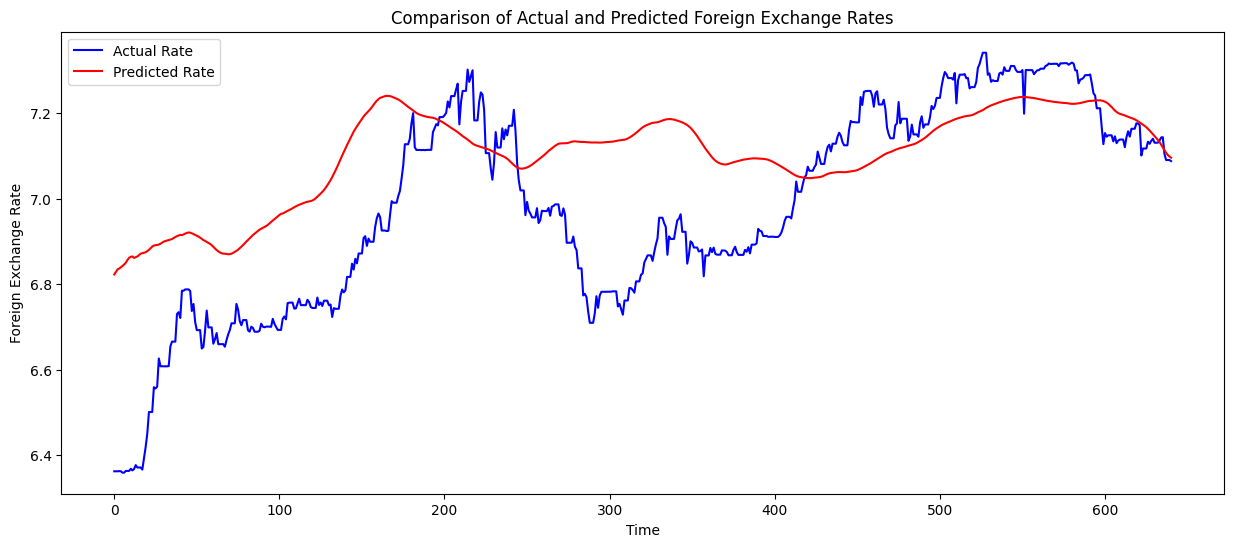

In [39]:
import matplotlib.pyplot as plt

y_test_original = output_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = output_scaler.inverse_transform(test_predict.reshape(-1, 1))

plt.figure(figsize=(15, 6))
plt.plot(y_test_original, label='Actual Rate', color='blue')
plt.plot(y_pred_original, label='Predicted Rate', color='red')
plt.title('Comparison of Actual and Predicted Foreign Exchange Rates')
plt.xlabel('Time')
plt.ylabel('Foreign Exchange Rate')
plt.legend()
plt.show()


## Timestep = 7

In [40]:
def create_sequences(features, target, time_steps=1):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 7
X_train, y_train = create_sequences(train_features, train_target.values, time_steps)
X_val, y_val = create_sequences(validation_features, validation_target.values, time_steps)
X_test, y_test = create_sequences(test_features, test_target.values, time_steps)




In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

short_model = Sequential([
    LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(30, return_sequences=True),
    Dropout(0.2),
    LSTM(30, return_sequences=False),
    Dense(1)
])

short_model.compile(optimizer='adam', loss='mean_squared_error')

short_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0466 - val_loss: 0.0290
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0048 - val_loss: 0.0151
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0034 - val_loss: 0.0150
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0023 - val_loss: 0.0171
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0019 - val_loss: 0.0207
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0018 - val_loss: 0.0201
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0016 - val_loss: 0.0213
Epoch 8/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0014 - val_loss: 0.0237
Epoch 9/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0014 - val_loss: 0.0211
Epoch 10/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0012 - val_loss: 0.0225
Epoch 11/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0011 - val_loss: 0.0231
Epoch 12/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/ste

In [42]:
test_predict = short_model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, test_predict)
rmse = mse**0.5
mae = mean_absolute_error(y_test, test_predict)
r2 = r2_score(y_test, test_predict)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)


Mean Squared Error: 0.012797864652780397
Root Mean Squared Error: 0.11312764760561583
Mean Absolute Error: 0.09017878073917629
R2 Score: 0.22408980753076957


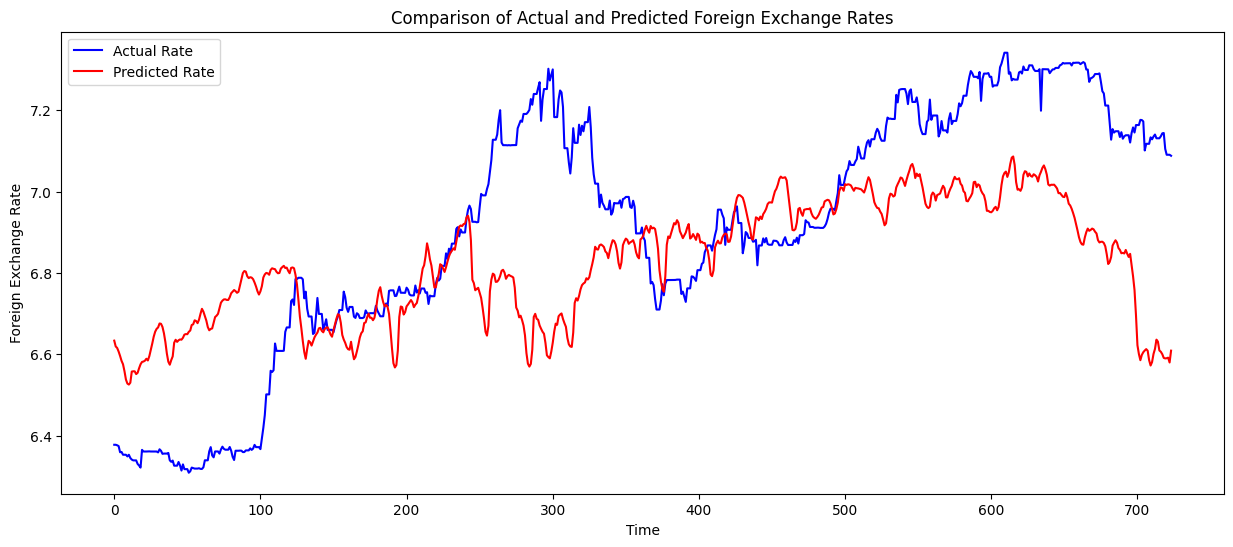

In [44]:
import matplotlib.pyplot as plt

y_test_original = output_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = output_scaler.inverse_transform(test_predict.reshape(-1, 1))

plt.figure(figsize=(15, 6))
plt.plot(y_test_original, label='Actual Rate', color='blue')
plt.plot(y_pred_original, label='Predicted Rate', color='red')
plt.title('Comparison of Actual and Predicted Foreign Exchange Rates')
plt.xlabel('Time')
plt.ylabel('Foreign Exchange Rate')
plt.legend()
plt.show()


## Timestep = 90

In [45]:
def create_sequences(features, target, time_steps=1):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 90
X_train, y_train = create_sequences(train_features, train_target.values, time_steps)
X_val, y_val = create_sequences(validation_features, validation_target.values, time_steps)
X_test, y_test = create_sequences(test_features, test_target.values, time_steps)




In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

long_model = Sequential([
    LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(30, return_sequences=True),
    Dropout(0.2),
    LSTM(30, return_sequences=False),
    Dense(1)
])

long_model.compile(optimizer='adam', loss='mean_squared_error')

long_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 27s 110ms/step - loss: 0.0135 - val_loss: 0.0187
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 103ms/step - loss: 0.0024 - val_loss: 0.0227
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 110ms/step - loss: 0.0016 - val_loss: 0.0275
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - loss: 0.0013 - val_loss: 0.0258
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - loss: 0.0011 - val_loss: 0.0367
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - loss: 0.0012 - val_loss: 0.0374
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 107ms/step - loss: 6.9094e-04 - val_loss: 0.0444
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - loss: 7.2057e-04 - val_loss: 0.0427
Epoch 9/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - loss: 6.2605e-04 - val_loss: 0.0447
Epoch 10/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - loss: 5.6418e-04 - val_loss: 0.0456
Epoch 11/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - loss: 4.3620e-04 - val_loss: 0.0462

In [47]:
test_predict = long_model.predict(X_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, test_predict)
rmse = mse**0.5
mae = mean_absolute_error(y_test, test_predict)
r2 = r2_score(y_test, test_predict)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)


Mean Squared Error: 0.010134920646629656
Root Mean Squared Error: 0.10067234300754928
Mean Absolute Error: 0.08103932837826604
R2 Score: 0.010455347458754094


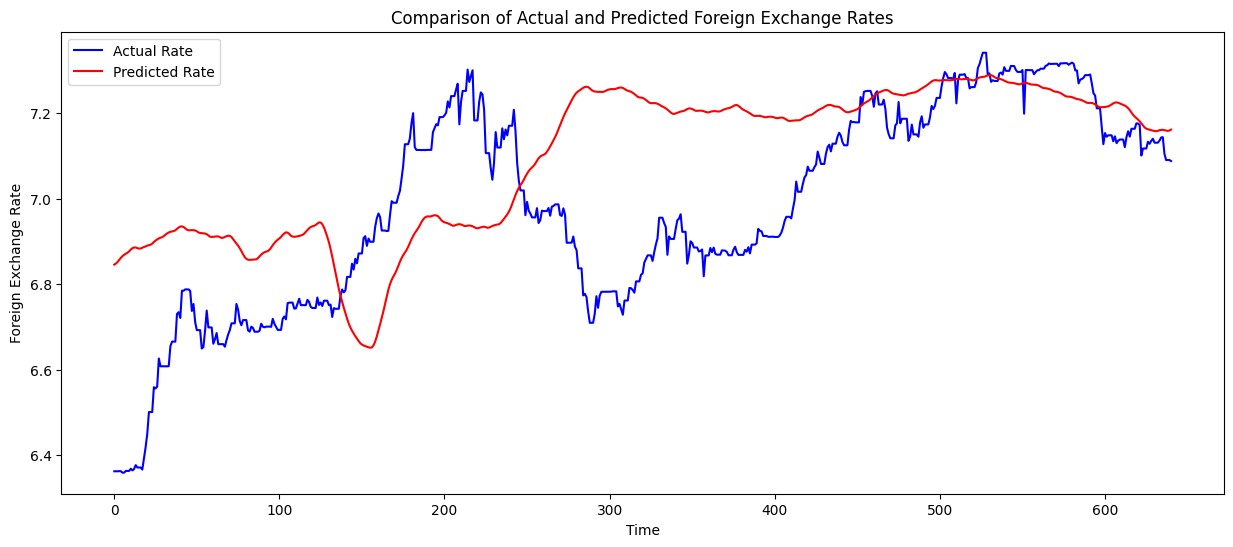

In [49]:
import matplotlib.pyplot as plt

y_test_original = output_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = output_scaler.inverse_transform(test_predict.reshape(-1, 1))

plt.figure(figsize=(15, 6))
plt.plot(y_test_original, label='Actual Rate', color='blue')
plt.plot(y_pred_original, label='Predicted Rate', color='red')
plt.title('Comparison of Actual and Predicted Foreign Exchange Rates')
plt.xlabel('Time')
plt.ylabel('Foreign Exchange Rate')
plt.legend()
plt.show()
